# Aplicación de un Modelo de Interacción Espacial a datos departamentales

Datos utilizados como variables independientes:

- La población total en origen y destino
- Totales de personas que declaran haber vivido antes en el departamento de origen
- Distancias y logaritmo de la distancia entre centros medios de población
- Dummy de límites compartidos
- Largo del límite compartido
- El PBI en el departamento de destino y el logaritmo de dicho valor

In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error
import tabulate
from operator import add

from shapely import wkt
from shapely.geometry import shape, LineString, Point
    
# funciones desarrolladas
from functions.agrupar_dfs_censo import *
from functions.cargar_data import *
from functions.impresion import *

In [2]:
# carga capas de datos geográficos
deptos, deptos_sim, localidad, centro_pobl, capital = cargar_datos_geo()

# carga migrantes internos
p_migr = cargar_migrantes_internos()

# carga poblacion por depto
pobl = recuperar_poblacion_2011()

# carga datos diádicos
dd_deptos = pd.read_csv('tablas/dd_deptos.csv')
dd_deptos.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_100k,pob_origen,pob_destino,dist,pbi_origen,pbi_porcen_ori,pbi_destino,pbi_porcen_des,largo_limite,dummy_limit,empresas_origen,empresas_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des
0,102,1,2,914,891,1318755,73377,610726,465848031,50.3,14214980,1.5,NaN,False,3124,55,16.469807,13.322404,MONTEVIDEO,ARTIGAS
1,103,1,3,33127,0,1318755,520173,22544,465848031,50.3,86306492,9.3,60107.0,True,3124,563,18.273415,10.023224,MONTEVIDEO,CANELONES
2,104,1,4,1387,1349,1318755,84698,393703,465848031,50.3,17048887,1.8,NaN,False,3124,88,16.651595,12.883352,MONTEVIDEO,CERRO LARGO
3,105,1,5,2100,1991,1318755,123203,172773,465848031,50.3,43788749,4.7,NaN,False,3124,60,17.594887,12.059734,MONTEVIDEO,COLONIA
4,106,1,6,982,924,1318755,57084,198970,465848031,50.3,13023942,1.4,NaN,False,3124,40,16.382300,12.200909,MONTEVIDEO,DURAZNO


Dada la menor complejidad, se comienza por el análisis de los flujos entre departamentos.
La base de personas del Censo INE 2011 se filtra según el siguiente criterio:
- Variable "PERMI07" (lugar de residencia 5 años antes) con valores:
    - 2 = en otra localidad o paraje de este departamento
    - 3 = en otro departamento
    
Se excluyen habitantes de localidades rurales.

La tabla resultante contiene un departamento de origen, uno de destino y una cantidad de personas que declaran haber vivido antes en el departamento de "origen", habiendo sido relevadas en el departamento de "destino" al momento de la aplicación del formulario censal.


### El perfil de la migración interna

Algunas características de la población migrante interna:

- el perfil más joven y feminizado de quienes migran hacia Montevideo.

- el perfil de familias completas, integradas por parejas de entre 30 y 40 años con niños, de quienes migran desde Montevideo.

In [3]:
# genera un sólo dataframe solo para deptos
flujos_deptos = p_migr[['depto_origen', 'depto_destino']]

flujos_deptos = flujos_deptos[flujos_deptos.depto_origen != flujos_deptos.depto_destino]

flujos_deptos['personas_mig'] = 1

# agrupa y cuenta
grupo = flujos_deptos.groupby(by=['depto_origen', 'depto_destino']).sum()

print('Cantidad de díadas ', grupo.shape[0])

# genera tabla pivot con los flujos de departamento a departamento
matrix = pd.pivot_table(flujos_deptos,
                        index ='depto_origen',
                        columns='depto_destino',
                        fill_value=0,
                        aggfunc=sum,
                        margins=True,
                        margins_name='Total')
matrix

Cantidad de díadas  342


personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

In [4]:
# define función para hacer lineas a partir de códigos origen-destino y una geografía conocida
# fuente: https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Unconstrained%20Spatial%20Interaction%20Models.ipynb

def _odline(orig, dest, geo, zonecode):
    return LineString([deptos[geo[zonecode] == orig].centroid.values[0], geo[geo[zonecode] == dest].centroid.values[0]])

# Makes a geodataframe of flows
def odflow(flowdata, origin, destination, flow_value, geo, zonecode):
    # First make all the lines
    lines = flowdata.apply(lambda x: _odline(x[origin], x[destination], geo, zonecode), axis=1)
    # Now get the series of flow values
    flows = flowdata[[flow_value, origin, destination]]
    # Now return a geodataframe
    return gpd.GeoDataFrame(flows, geometry=lines, crs = geo.crs)

# aplica dd_deptos
flows = odflow(dd_deptos,'depto_origen', 'depto_destino', 'personas_mig', deptos, 'cod_ine')

# guarda como geopaquete
# flows.to_file("capas/deptos_mig_recientes_2011.gpkg", layer='flujos', driver="GPKG")

In [5]:
def odflow(flowdata, origin, destination, flow_value, geo, zonecode):
    # First make all the lines
    lines = flowdata.apply(lambda x: _odline(x[origin], x[destination], geo, zonecode), axis=1)
    # Now get the series of flow values
    flows = flowdata[[flow_value, origin, destination]]
    # Now return a geodataframe
    return gpd.GeoDataFrame(flows, geometry=lines, crs = geo.crs)

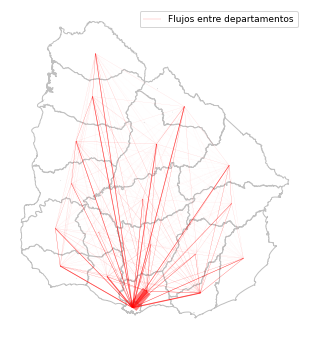

In [6]:
# plot de flujos
f, ax = plt.subplots(1,figsize=(8,6))

# apaga ejes
plt.axis('off')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# capa de departamentos
deptos.plot(color='w', edgecolor='silver' ,ax=ax)

# máximo de flujos para escalado
maxflow = float(max(flows['personas_mig']))

# título
# pl.title("Representación gráfica de las migraciones recientes", size=10)

# plotea flows, calcula ancha de línea con una función sobre 'personas_mig'
flows.plot(linewidth = flows.apply(lambda x: (x['personas_mig']/maxflow)*10, axis=1),
           color= 'red',
           ax=ax,
           label='Flujos entre departamentos',
           alpha=0.5)

ax.set_aspect('equal')

# referencias
plt.legend(fontsize=9)

metadatos_figs = {'Author': '''Guillermo D'Angelo'''}

# plt.savefig('mapas_graficas/links_depto.pdf',
#            bbox_inches='tight',
#            metadata = metadatos_figs )

## Gráficas de distancia

#### Totales

Text(0.5, 0, 'Distancia (km)')

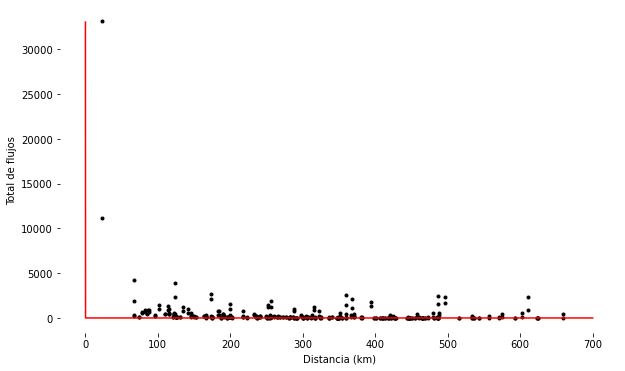

In [7]:
# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(dd_deptos['dist']/1000, dd_deptos['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.0055, 700, 1000)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# etiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (km)")

# se ven dos outlyers claramente, deben ser Mvdeo y Canelones.

#### Sin Montevideo

Text(0.5, 0, 'Distancia (km)')

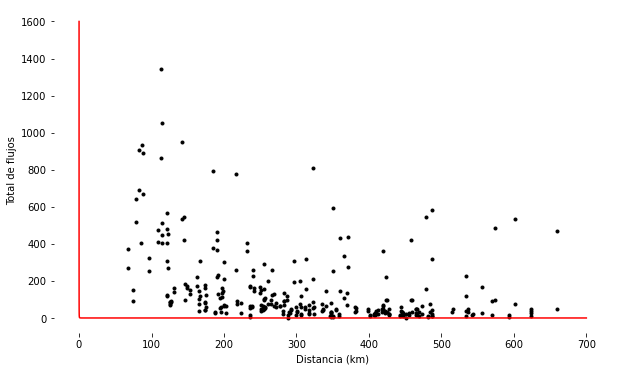

In [8]:
# mismo gráfico sin Mvdeo.
sin_mvo = dd_deptos[(dd_deptos['depto_origen'] > 1) & (dd_deptos['depto_destino'] > 1)]

# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(10,6))

# plot de los puntos
ax.scatter(sin_mvo['dist']/1000, sin_mvo['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.025, 700, 100)
yvals = np.power(xvals,-2.0)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# Etiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (km)")

Text(0.5, 0, 'Población en origen')

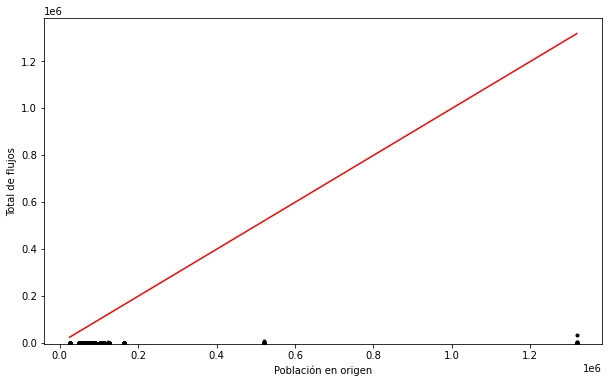

In [9]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(10,6))

# Plot data points
ax.scatter(dd_deptos['pob_origen'], dd_deptos['personas_mig'], marker='.', color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(dd_deptos['pob_origen'].min(), dd_deptos['pob_origen'].max(), 100)
yvals = np.power(xvals, 1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, dd_deptos['pob_origen'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Población en origen")

Text(0.5, 0, 'PBI en destino')

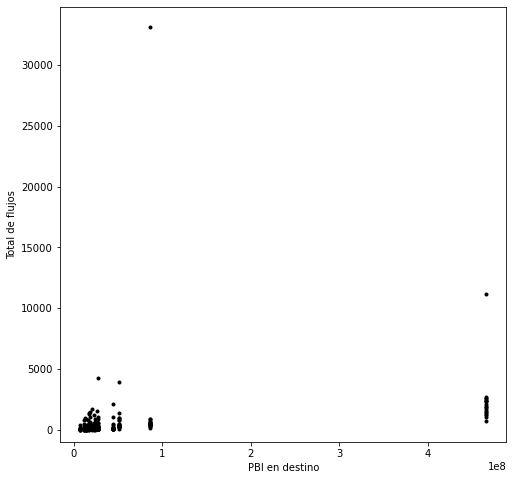

In [10]:
# Plot de PBI en destino contra personas migrantes
f, ax = plt.subplots(1,figsize=(8,8))

# Plot data points
ax.scatter(dd_deptos['pbi_destino'], dd_deptos['personas_mig'], marker='.',color='k')

# now work out the function y = x - basic linear slope with 0 origin.
xvals = np.linspace(dd_deptos['pbi_destino'].min(), dd_deptos['pbi_destino'].max(), 100)
yvals = np.power(xvals,1.0)

# Now add function line to plot
ax.plot(xvals, yvals, color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-1000, dd_deptos['personas_mig'].max()*1.05)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("PBI en destino")

## Modelo restringido en origen

1 $$T_{ij} = A_{i}O_{i}W_{j}^{\alpha}d_{ij}^{-\beta}$$

dónde

2 $$O_{i} = \sum_{j}T_{ij}$$
3 $$A_{i} = \frac{1}{\sum_{j}W_{j}^{\alpha}d_{ij}^{-\beta}}$$

En el modelo restringido en origen $O_{i}$ no tiene parámetro dado que representa valores conocidos. $A_{i}$ es un factor de balance que refiere a cada origen $i$. Más específicamente $A_{i}$ permite que la suma de los valores estimados sea igual al total conocido $O_{i}$

El modelo es re-especificado como un modelo de regresión de Poisson, aplicando el logaritmo, transformando la ecuación 1 en la siguiente:

4   $$ \lambda_{ij} = \exp( \mu_{i} + \alpha \ln W_{j} - \beta \ln d_{ij} )$$


En el modelo re-especificado, $\mu_{i}$ suplanta a $A_{i}O_{i}$.



In [11]:
# carga datos guardados previamente
# respalda el objeto para usarlo en el otro modelo
dd_deptos_ps = pd.read_csv('tablas/dd_deptos.csv')
dd_deptos_ps.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_100k,pob_origen,pob_destino,dist,pbi_origen,pbi_porcen_ori,pbi_destino,pbi_porcen_des,largo_limite,dummy_limit,empresas_origen,empresas_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des
0,102,1,2,914,891,1318755,73377,610726,465848031,50.3,14214980,1.5,NaN,False,3124,55,16.469807,13.322404,MONTEVIDEO,ARTIGAS
1,103,1,3,33127,0,1318755,520173,22544,465848031,50.3,86306492,9.3,60107.0,True,3124,563,18.273415,10.023224,MONTEVIDEO,CANELONES
2,104,1,4,1387,1349,1318755,84698,393703,465848031,50.3,17048887,1.8,NaN,False,3124,88,16.651595,12.883352,MONTEVIDEO,CERRO LARGO
3,105,1,5,2100,1991,1318755,123203,172773,465848031,50.3,43788749,4.7,NaN,False,3124,60,17.594887,12.059734,MONTEVIDEO,COLONIA
4,106,1,6,982,924,1318755,57084,198970,465848031,50.3,13023942,1.4,NaN,False,3124,40,16.382300,12.200909,MONTEVIDEO,DURAZNO


Especificación del modelo sin intercepto (dado por el valor -1 en la fórmula).

Esto quiere decir que todos lo AiOis son estimados contra in intercepto de 0.

Incluir el intervalo significaría usar el primer departamento en la variable "nom_depto_orig" como intercepto, e interpretar todas las demás categorías con respecto a eso.

In [12]:
# define el string tomado como fórmula
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist -1"

# entrena y ajusta el modelo
prodSim = smf.glm(formula=formula, data=dd_deptos_ps, family = sm.families.Poisson()).fit()

# resultados
prodSim.summary()

# la desviación y el coef de chi cuadrado no son buenas señales
# https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
# https://www.medcalc.org/manual/chi-square-table.php

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      321
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14973.
Date:                Sun, 15 Aug 2021   Deviance:                       27718.
Time:                        19:17:17   Pearson chi2:                 3.00e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]            0.8906      0.075     11.948      0.000       0.745       1.037
nom_depto_orig[CANELONES]          0.3788      0.069      5.491      0.000       0.244       0.514
nom_depto_orig[CERRO LARGO]        0.5190      0.074      6.988      0.000       0.373       0.665
nom_depto_orig[COLONIA]            0.1648      0.073      2.255      0.024       0.022       0.308
nom_depto_orig[DURAZNO]           -0.0837      0.073     -1.140      0.254      -0.227       0.060
nom_depto_orig[FLORES]            -1.0428      0.075    -13.842      0.000      -1.190      -0.895
nom_depto_orig[FLORIDA]           -0.3389      0.073     -4.672      0.000      -0.481      -0.197
nom_depto_orig[LAVALLEJA]         -0.3429      0.073     -4.688      0.000      -0.486      -0.200
nom_depto_orig[MALDONADO]          0.2271      0.073      3.128      0.002       0.085       0.369
nom_depto_orig[MONTEVIDEO]         2.5748      0.067     38.545      0.000       2.444       2.706
nom_depto_orig[PAYSANDU]           0.5033      0.073      6.882      0.000       0.360       0.647
nom_depto_orig[RIO NEGRO]         -0.0120      0.073     -0.164      0.870      -0.156       0.132
nom_depto_orig[RIVERA]             0.7054      0.074      9.489      0.000       0.560       0.851
nom_depto_orig[ROCHA]              0.0459      0.074      0.618      0.537      -0.100       0.192
nom_depto_orig[SALTO]              0.7632      0.074     10.334      0.000       0.618       0.908
nom_depto_orig[SAN JOSE]          -0.4887      0.072     -6.775      0.000      -0.630      -0.347
nom_depto_orig[SORIANO]            0.2470      0.073      3.389      0.001       0.104       0.390
nom_depto_orig[TACUAREMBO]         0.6533      0.074      8.878      0.000       0.509       0.798
nom_depto_orig[TREINTA Y TRES]    -0.0210      0.074     -0.283      0.777      -0.167       0.125
log_pbi_destino                    0.8527      0.002    355.615      0.000       0.848       0.857
log_dist                          -0.7834      0.003   -224.855      0.000      -0.790      -0.777
==================================================================================================
"""

In [13]:
# guarda en latex
# prodSim_latex = prodSim.summary().as_latex()
# f = open("tablas/prodSim.tex", "w")
# f.write(prodSim_latex)
# f.close()

In [14]:
# funciones para recuperar parámetros e imprimir
def get_gml_params(model, variables):
    "Accede a los parámetros alfa y beta dentro de los resutaldos del modelo"
    params = [model.params[i] for i in variables]
    params_str = [str(round(i, 4)) for i in params]
    return params, params_str

def print_params(variables, params_list):
    "Imprime los parámetros"
    return print("""alpha ({}) = {}\nbeta ({}) = {}
    """.format(variables[0], params_list[0], variables[1], params_list[1]))

In [15]:
# imprime parámetros
variables= ['log_pbi_destino', 'log_dist']

params, params_str = get_gml_params(prodSim, variables)

print_params(variables, params_str)

alpha (log_pbi_destino) = 0.8527
beta (log_dist) = -0.7834
    


De los resultados se desprende un parámetro $\alpha$ relacionado a la actractividad del destino de **0,8527**.

El parámetro $\beta$ relativo al decaimiento por la distancia es de **-0,7830**.

El coeficiente para cada origen es el valor registrado $A_{i}O_{i}$ para ese origen.

### Estimación del modelo restringido en origen

Los parámetros calculados se insertan en la ecuación presentada anteriormente:

In [16]:
# imprime la ecuación
alpha = params_str[0]
beta =  params_str[1]
ij = '{ij}'

def get_eq_string(alpha, beta):
    eq_str='''\lambda_{2} = \exp( \mu_i + {0} ln W_j  + ({1} ln d_{2}))'''.format(alpha, beta, ij)
    return eq_str

printmath(get_eq_string(alpha, beta))

<IPython.core.display.Math object>

In [17]:
# crea la sumatoria de migrantes en origen (Oi)
O_i = dd_deptos_ps.groupby('depto_origen')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'O_i'})

# crea la sumatoria de migrantes en destino (Di)
D_j = dd_deptos_ps.groupby('depto_destino')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'D_j'})

# pega ambas variables con el df
dd_deptos_ps = dd_deptos_ps.merge(O_i, left_on='depto_origen', right_index=True)
dd_deptos_ps = dd_deptos_ps.merge(D_j, left_on='depto_destino', right_index=True)

dd_deptos_ps.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_100k,pob_origen,pob_destino,dist,pbi_origen,pbi_porcen_ori,...,largo_limite,dummy_limit,empresas_origen,empresas_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des,O_i,D_j
0,102,1,2,914,891,1318755,73377,610726,465848031,50.3,...,NaN,False,3124,55,16.469807,13.322404,MONTEVIDEO,ARTIGAS,58655,1810
37,302,3,2,74,70,520173,73377,601915,86306492,9.3,...,NaN,False,563,55,16.469807,13.307872,CANELONES,ARTIGAS,17233,1810
55,402,4,2,15,14,84698,73377,406694,17048887,1.8,...,NaN,False,88,55,16.469807,12.915816,CERRO LARGO,ARTIGAS,4459,1810
73,502,5,2,28,25,123203,73377,556292,43788749,4.7,...,NaN,False,60,55,16.469807,13.229049,COLONIA,ARTIGAS,4752,1810
91,602,6,2,32,29,57084,73377,446123,13023942,1.4,...,NaN,False,40,55,16.469807,13.008350,DURAZNO,ARTIGAS,3757,1810


In [18]:
# recupera los parámetros del modelo
mu_i = prodSim.params.to_frame()

# elimina caractérres no numéricos para poder pegar
mu_i.rename(index = dict(zip(mu_i.index[0:-2].values, mu_i.index[0:-2].str.replace(r'[^ ABCDEFGHIJKLMNÑOPQRSTUVWXYZ]','', regex=True).values)),
            inplace=True)

# renombre columna
mu_i.rename(columns = {0:'mu_i'}, inplace=True)

# merge
dd_deptos_ps = dd_deptos_ps.merge(mu_i, left_on='nom_depto_orig', right_index=True)

dd_deptos_ps.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_100k,pob_origen,pob_destino,dist,pbi_origen,pbi_porcen_ori,...,dummy_limit,empresas_origen,empresas_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des,O_i,D_j,mu_i
0,102,1,2,914,891,1318755,73377,610726,465848031,50.3,...,False,3124,55,16.469807,13.322404,MONTEVIDEO,ARTIGAS,58655,1810,2.574775
1,103,1,3,33127,0,1318755,520173,22544,465848031,50.3,...,True,3124,563,18.273415,10.023224,MONTEVIDEO,CANELONES,58655,41413,2.574775
2,104,1,4,1387,1349,1318755,84698,393703,465848031,50.3,...,False,3124,88,16.651595,12.883352,MONTEVIDEO,CERRO LARGO,58655,3001,2.574775
3,105,1,5,2100,1991,1318755,123203,172773,465848031,50.3,...,False,3124,60,17.594887,12.059734,MONTEVIDEO,COLONIA,58655,5462,2.574775
4,106,1,6,982,924,1318755,57084,198970,465848031,50.3,...,False,3124,40,16.382300,12.200909,MONTEVIDEO,DURAZNO,58655,2571,2.574775


In [19]:
# genera estimación redondeada
def prod_sim_est(df, variables, alpha, beta):
    "Estimación del modelo imputando los parámetros alfa y beta previamente calculados"
    prodsimest = np.exp(df['mu_i'] + alpha * df[variables[0]] + beta * df[variables[1]])
    return round(prodsimest)

In [20]:
# recupera alpha y beta, previamente guardados en la lista de parámetros
alpha, beta = [i for i in params]

# estima y guarda en columna "podsimtest"
dd_deptos_ps['prodsimest'] = prod_sim_est(dd_deptos_ps, variables, alpha, beta)
dificil=prod_sim_est(dd_deptos_ps, variables, alpha, beta)

#### La forma fácil, aprovechando *statsmodel*

In [21]:
# a pesar de lo anterior, se podrían acceder directamente a las predicciones
del dd_deptos_ps
dd_deptos_ps = pd.read_csv('tablas/dd_deptos.csv')
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist -1"
model = smf.glm(formula=formula, data=dd_deptos_ps, family = sm.families.Poisson())
prodSim = model.fit()

# predicción
pred = prodSim.get_prediction(dd_deptos_ps)
dd_deptos_ps['prodsimest'] = pred.summary_frame()['mean'].round(0).astype(int)

In [22]:
dd_deptos_ps.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_100k,pob_origen,pob_destino,dist,pbi_origen,pbi_porcen_ori,...,pbi_porcen_des,largo_limite,dummy_limit,empresas_origen,empresas_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des,prodsimest
0,102,1,2,914,891,1318755,73377,610726,465848031,50.3,...,1.5,NaN,False,3124,55,16.469807,13.322404,MONTEVIDEO,ARTIGAS,484
1,103,1,3,33127,0,1318755,520173,22544,465848031,50.3,...,9.3,60107.0,True,3124,563,18.273415,10.023224,MONTEVIDEO,CANELONES,29872
2,104,1,4,1387,1349,1318755,84698,393703,465848031,50.3,...,1.8,NaN,False,3124,88,16.651595,12.883352,MONTEVIDEO,CERRO LARGO,797
3,105,1,5,2100,1991,1318755,123203,172773,465848031,50.3,...,4.7,NaN,False,3124,60,17.594887,12.059734,MONTEVIDEO,COLONIA,3397
4,106,1,6,982,924,1318755,57084,198970,465848031,50.3,...,1.4,NaN,False,3124,40,16.382300,12.200909,MONTEVIDEO,DURAZNO,1081


In [23]:
# comparación de las predicciones con ambas formas, debe dar suma cerp
facil = pred.summary_frame()['mean'].round(0).astype(float)
print(sum(facil-dificil))

0.0


In [24]:
# matriz de flujos estimada por el modelo
dd_deptos_ps['depto_origen'] = dd_deptos_ps.depto_origen.astype(int)

matrix_prodsim = pd.pivot_table(dd_deptos_ps,
                                values='prodsimest',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_prodsim.Total = matrix_prodsim.Total.astype(int)

matrix_prodsim

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,484,29872,797,3397,1081,705,2378,1714,5034,1237,1285,769,1159,953,4712,1438,900,739,58654
2,1761,0,423,144,252,107,64,121,99,253,266,206,337,106,378,163,173,219,92,5164
3,14004,54,0,93,351,125,81,297,216,602,140,144,87,137,107,445,161,102,88,17234
4,1713,85,426,0,198,107,54,120,128,305,137,117,173,147,135,144,115,153,202,4459
5,2291,47,505,62,0,97,85,129,86,229,150,184,70,73,106,263,242,83,50,4752
6,1601,43,394,74,212,0,100,145,87,197,115,113,73,71,87,156,125,100,65,3758
7,657,16,162,24,117,63,0,54,30,73,56,57,27,24,37,80,67,35,20,1599
8,2092,29,557,49,168,86,51,0,95,217,77,74,48,63,57,192,80,59,47,4041
9,1679,27,451,58,125,58,31,106,0,362,60,57,44,93,47,120,61,49,62,3490


In [25]:
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

In [26]:
# se define este diccionario para recodificar el índice, con abreviaturas
deptos_dict = {
    1:	'Mvdeo.',
    2:	'Artigas',
    3:	'Can.',
    4:	'C. Largo',
    5:	'Colonia',
    6:	'Durazno',
    7:	'Flores',
    8:	'Florida',
    9:	'Lavalleja',
    10:	'Maldonado',
    11:	'Paysandú',
    12:	'R. Negro',
    13:	'Rivera',
    14:	'Rocha',
    15:	'Salto',
    16:	'San José',
    17:	'Soriano',
    18:	'Tacuarembó',
    19:	'T. y Tres'
        }

In [27]:
# se determina el formato de columnas para exportación en latex
def format_cols_latex(ancho, ncols):
    colformato = 'lp{' + ancho + 'cm}' + ('p{' + ancho + 'cm}') * ncols
    return colformato

colformato = format_cols_latex('0.7', 19 )

In [28]:
# exporta a latex
matrix_prodsim_tex = matrix_prodsim.rename(index=deptos_dict)

# matrix_prodsim_tex.to_latex(buf= "tablas/prodsim_matriz_orig_dest.tex",
# bold_rows=False,
# column_format = colformato,
# float_format="%.2f",
# caption= 'Matriz de movimientos entre departamentos estimada mediante SIM restringido en origen.')

Se puede identificar la coincidencia de la matriz de los datos originales con la de los datos estimados en la columna de origen $O_{i}$, con leves diferencias producto del redondeo.

$$\sum_{j}T_{ij} = \sum_{j}\lambda_{ij} = O_{i}$$

In [29]:
def print_scores(df, gt, est, modelo):
    r2 = r2_score(df[gt], df[est])
    rmse = mean_squared_error(df[gt], df[est], squared=False)
    
    printmd('**Bondad de ajuste del modelo {}**'.format(modelo))
    printmd("$R²$ = " + round(r2, 4).astype(str))
    printmd("RMSE = " + round(rmse, 4).astype(str))

print_scores(dd_deptos_ps, 'personas_mig', 'prodsimest', 'restringido en origen')

**Bondad de ajuste del modelo restringido en origen**

$R²$ = 0.9726

RMSE = 322.431

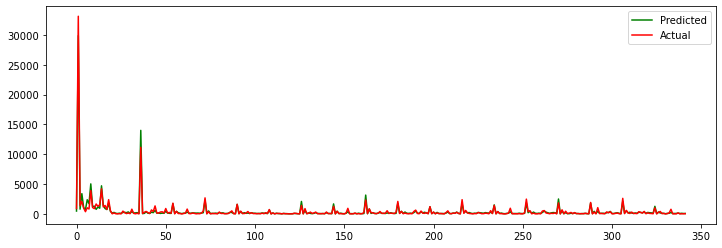

In [30]:
predicted_counts = dd_deptos_ps.prodsimest.values
actual_counts =    dd_deptos_ps.personas_mig.values

fig = plt.figure(figsize=(12, 4))

predicted, = plt.plot(dd_deptos_ps.index, predicted_counts, 'g-', label='Predicted')
actual, = plt.plot(dd_deptos_ps.index, actual_counts, 'r-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

In [31]:
# con train-test split
del dd_deptos_ps
dd_deptos_ps = pd.read_csv('tablas/dd_deptos.csv')

mask = np.random.rand(len(dd_deptos_ps)) < 0.8

df_train = dd_deptos_ps[mask]
df_test = dd_deptos_ps[~mask]

In [32]:
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist -1"
model = smf.glm(formula=formula, data=df_train, family = sm.families.Poisson())
prodSim = model.fit()

# predicción
pred = prodSim.get_prediction(df_test)
pred.summary_frame()['mean'].round(0).astype(int)

0     5335
1     1542
2      786
3      255
4      317
      ... 
61     110
62      52
63     172
64      57
65      53
Name: mean, Length: 66, dtype: int64

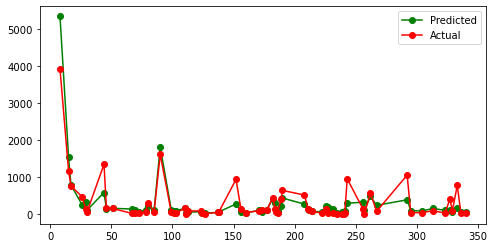

In [33]:
predicted_counts = pred.summary_frame()['mean'].round(0).astype(int)
actual_counts = df_test.personas_mig

fig = plt.figure(figsize=(8, 4))

predicted, = plt.plot(df_test.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(df_test.index, actual_counts, 'ro-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

Text(0, 0.5, 'Groud truth')

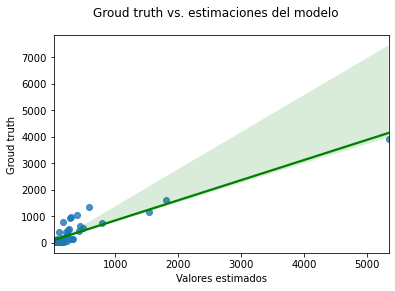

In [34]:
fig = plt.figure()
sns.regplot(x=predicted_counts, y=actual_counts, line_kws={"color": "green"})

fig.suptitle('Groud truth vs. estimaciones del modelo')
plt.xlabel('Valores estimados')
plt.ylabel('Groud truth')

In [35]:
# genera matriz de diferencias
gt_array = matrix.iloc[0:19, 0:19].values
pred_array = matrix_prodsim.iloc[0:19, 0:19].values

delta = abs(gt_array-pred_array).astype(np.double).round(0)
np.fill_diagonal(delta, np.nan)

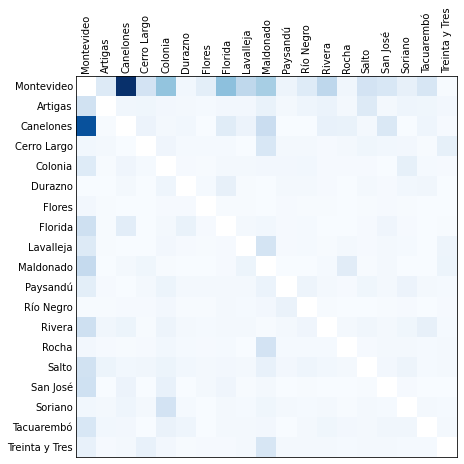

In [36]:
# imprime la matriz de las diferencias
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111)
cax = ax.matshow(delta, cmap='Blues')

nomdep = cargar_nombres()
plt.xticks(np.arange(0, 19, step=1), labels=nomdep, rotation=90)
plt.yticks(np.arange(0, 19, step=1), labels=nomdep)

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

#### **Otro modelo restringido en producción con la *dummy* de límites compartidos como predictor**

**Este modelo es similar al aplicado en R, devolviendo los mismos resultados en ambas plataformas**

In [37]:
# recarga data
dd_deptos_ps = pd.read_csv('tablas/dd_deptos.csv')
dd_deptos_ps.loc[dd_deptos_ps.largo_limite.isna(), 'largo_limite'] = 0.0001
dd_deptos_ps.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_100k,pob_origen,pob_destino,dist,pbi_origen,pbi_porcen_ori,pbi_destino,pbi_porcen_des,largo_limite,dummy_limit,empresas_origen,empresas_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des
0,102,1,2,914,891,1318755,73377,610726,465848031,50.3,14214980,1.5,0.0001,False,3124,55,16.469807,13.322404,MONTEVIDEO,ARTIGAS
1,103,1,3,33127,0,1318755,520173,22544,465848031,50.3,86306492,9.3,60107.0000,True,3124,563,18.273415,10.023224,MONTEVIDEO,CANELONES
2,104,1,4,1387,1349,1318755,84698,393703,465848031,50.3,17048887,1.8,0.0001,False,3124,88,16.651595,12.883352,MONTEVIDEO,CERRO LARGO
3,105,1,5,2100,1991,1318755,123203,172773,465848031,50.3,43788749,4.7,0.0001,False,3124,60,17.594887,12.059734,MONTEVIDEO,COLONIA
4,106,1,6,982,924,1318755,57084,198970,465848031,50.3,13023942,1.4,0.0001,False,3124,40,16.382300,12.200909,MONTEVIDEO,DURAZNO


In [38]:
# define el string tomado como fórmula
formula = "personas_mig ~ nom_depto_orig + dummy_limit + np.log(largo_limite) + log_pbi_destino + pbi_porcen_des + log_dist -1"

# entrena y ajusta el modelo
prodSim = smf.glm(formula=formula, data=dd_deptos_ps, family = sm.families.Poisson()).fit()

# resultados
prodSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      318
Model Family:                 Poisson   Df Model:                           23
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9050.1
Date:                Sun, 15 Aug 2021   Deviance:                       15872.
Time:                        19:18:14   Pearson chi2:                 1.77e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]          -10.7752      0.192    -56.217      0.000     -11.151     -10.400
nom_depto_orig[CANELONES]        -10.6602      0.183    -58.143      0.000     -11.020     -10.301
nom_depto_orig[CERRO LARGO]      -11.0359      0.190    -58.063      0.000     -11.408     -10.663
nom_depto_orig[COLONIA]          -11.0233      0.187    -58.839      0.000     -11.390     -10.656
nom_depto_orig[DURAZNO]          -11.3842      0.188    -60.592      0.000     -11.752     -11.016
nom_depto_orig[FLORES]           -12.2325      0.189    -64.824      0.000     -12.602     -11.863
nom_depto_orig[FLORIDA]          -11.5357      0.187    -61.554      0.000     -11.903     -11.168
nom_depto_orig[LAVALLEJA]        -11.7013      0.189    -61.994      0.000     -12.071     -11.331
nom_depto_orig[MALDONADO]        -10.9373      0.188    -58.313      0.000     -11.305     -10.570
nom_depto_orig[MONTEVIDEO]        -8.3168      0.185    -44.891      0.000      -8.680      -7.954
nom_depto_orig[PAYSANDU]         -10.9962      0.189    -58.161      0.000     -11.367     -10.626
nom_depto_orig[RIO NEGRO]        -11.4450      0.189    -60.665      0.000     -11.815     -11.075
nom_depto_orig[RIVERA]           -10.9134      0.191    -57.147      0.000     -11.288     -10.539
nom_depto_orig[ROCHA]            -11.4046      0.190    -60.136      0.000     -11.776     -11.033
nom_depto_orig[SALTO]            -10.8857      0.190    -57.143      0.000     -11.259     -10.512
nom_depto_orig[SAN JOSE]         -11.6378      0.190    -61.406      0.000     -12.009     -11.266
nom_depto_orig[SORIANO]          -11.1342      0.188    -59.129      0.000     -11.503     -10.765
nom_depto_orig[TACUAREMBO]       -10.9736      0.190    -57.748      0.000     -11.346     -10.601
nom_depto_orig[TREINTA Y TRES]   -11.4521      0.189    -60.564      0.000     -11.823     -11.082
dummy_limit[T.True]               -4.9019      0.105    -46.514      0.000      -5.108      -4.695
np.log(largo_limite)               0.2969      0.005     56.210      0.000       0.287       0.307
log_pbi_destino                    1.2131      0.008    155.858      0.000       1.198       1.228
pbi_porcen_des                    -0.0139      0.000    -28.883      0.000      -0.015      -0.013
log_dist                          -0.1723      0.007    -25.119      0.000      -0.186      -0.159
==================================================================================================
"""

In [39]:
pred = prodSim.get_prediction(dd_deptos_ps)

dd_deptos_ps['prodsimest'] = pred.summary_frame()['mean'].round(0).astype(int)

print_scores(dd_deptos_ps, 'personas_mig', 'prodsimest', 'restringido en origen')

**Bondad de ajuste del modelo restringido en origen**

$R²$ = 0.988

RMSE = 213.5679

In [40]:
dd_deptos_ps['prodsimest'].head()

0      745
1    31588
2      998
3     3468
4      814
Name: prodsimest, dtype: int64

#### Mismo modelo excluyendo Mvdeo.

In [41]:
# recarga data
dd_deptos_ps = pd.read_csv('tablas/dd_deptos.csv')
dd_deptos_ps.loc[dd_deptos_ps.largo_limite.isna(), 'largo_limite'] = 0.0001

dd_deptos_ps_sin_mvo = dd_deptos_ps.loc[~((dd_deptos_ps.depto_origen==1) | (dd_deptos_ps.depto_destino==1))].reset_index(drop=True).copy()
print(dd_deptos_ps_sin_mvo.shape)
dd_deptos_ps_sin_mvo.head()

(306, 20)


,cod,depto_origen,depto_destino,personas_mig,personas_mig_100k,pob_origen,pob_destino,dist,pbi_origen,pbi_porcen_ori,pbi_destino,pbi_porcen_des,largo_limite,dummy_limit,empresas_origen,empresas_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des
0,203,2,3,536,491,73377,520173,601915,14214980,1.5,86306492,9.3,0.0001,False,55,563,18.273415,13.307872,ARTIGAS,CANELONES
1,204,2,4,20,15,73377,84698,406688,14214980,1.5,17048887,1.8,0.0001,False,55,88,16.651595,12.915802,ARTIGAS,CERRO LARGO
2,205,2,5,167,163,73377,123203,556293,14214980,1.5,43788749,4.7,0.0001,False,55,60,17.594887,13.229050,ARTIGAS,COLONIA
3,206,2,6,33,26,73377,57084,446123,14214980,1.5,13023942,1.4,0.0001,False,55,40,16.382300,13.008350,ARTIGAS,DURAZNO
4,207,2,7,21,14,73377,25050,450737,14214980,1.5,7284124,0.8,0.0001,False,55,28,15.801208,13.018639,ARTIGAS,FLORES


In [56]:
# entrena y ajusta el modelo
model = smf.glm(formula=formula, data=dd_deptos_ps_sin_mvo, family = sm.families.Poisson())
prodSim = model.fit()

# guarda el modelo
import pickle    
with open('modelos/restringido_rogein_v1.pkl','w') as f:
    pickle.dump(model, f)

# resultados
prodSim.summary()

TypeError: write() argument must be str, not bytes

In [43]:
pred = prodSim.get_prediction(dd_deptos_ps_sin_mvo)

dd_deptos_ps_sin_mvo['prodsimest'] = pred.summary_frame()['mean'].round(0).astype(int)

dd_deptos_ps_sin_mvo.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_100k,pob_origen,pob_destino,dist,pbi_origen,pbi_porcen_ori,...,pbi_porcen_des,largo_limite,dummy_limit,empresas_origen,empresas_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des,prodsimest
0,203,2,3,536,491,73377,520173,601915,14214980,1.5,...,9.3,0.0001,False,55,563,18.273415,13.307872,ARTIGAS,CANELONES,458
1,204,2,4,20,15,73377,84698,406688,14214980,1.5,...,1.8,0.0001,False,55,88,16.651595,12.915802,ARTIGAS,CERRO LARGO,81
2,205,2,5,167,163,73377,123203,556293,14214980,1.5,...,4.7,0.0001,False,55,60,17.594887,13.229050,ARTIGAS,COLONIA,201
3,206,2,6,33,26,73377,57084,446123,14214980,1.5,...,1.4,0.0001,False,55,40,16.382300,13.008350,ARTIGAS,DURAZNO,58
4,207,2,7,21,14,73377,25050,450737,14214980,1.5,...,0.8,0.0001,False,55,28,15.801208,13.018639,ARTIGAS,FLORES,31


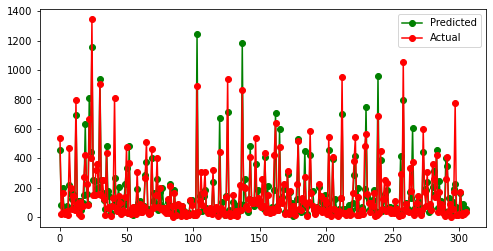

In [44]:
predicted_counts = dd_deptos_ps_sin_mvo.prodsimest
actual_counts = dd_deptos_ps_sin_mvo.personas_mig

fig = plt.figure(figsize=(8, 4))

predicted, = plt.plot(dd_deptos_ps_sin_mvo.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(dd_deptos_ps_sin_mvo.index, actual_counts, 'ro-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

Text(0, 0.5, 'Groud truth')

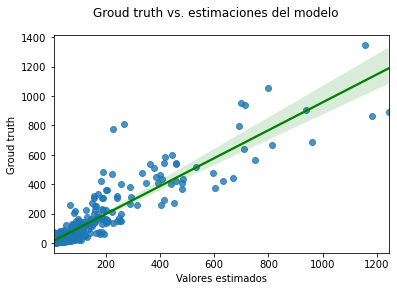

In [45]:
fig = plt.figure()
sns.regplot(x=predicted_counts, y=actual_counts, line_kws={"color": "green"})

fig.suptitle('Groud truth vs. estimaciones del modelo')
plt.xlabel('Valores estimados')
plt.ylabel('Groud truth')

# Modelo de doble restricción

5    $$ T_{ij} = A_{i}O_{i}B_{i}D_{j}d_{ij}^{-\beta }$$

dónde

6 $$O_{i} = \sum_{j}T_{ij}$$

7 $$D_{j} = \sum_{i}T_{ij}$$

8 $$A_{i} = \frac{1}{\sum_{j}B_{j}D_{j}d_{ij}^{-\beta}}$$

9 $$B_{j} = \frac{1}{\sum_{j}A_{i}O_{j}d_{ij}^{-\beta}}$$

La dificultad es que $A_{i}$ depende de $B_{j}$ y viceversa. Pero se puede arrivar a un valor para ambos factores fijando el valor de $B$ inicialmente como 1, y luego iterando refinando el valor de cada uno hasta que sea estable (converjan).

La limitación del modelo de doble restricción es que no se le pueden agregar variables específicas del origen o del destino.

In [46]:
# Modelo de restricción doble

# recupera los datos del respaldo
dd_deptos_dc =  pd.read_csv('tablas/dd_deptos.csv')

# siguiendo a Dennett y la guía de R, cambiamos la fórmula, borrando el "-1" al final es decir que se mantiene la intersección

# The code below has changed a litte from the singly constrained models I have removed the ‘-1’  which means that an intercept will appear in the model again. This is not because I want an intercept as it makes the origin and destination coefficients harder to interpret - reference categories zones will appear and the coefficients will need to be compared with the intercept - rather the ‘-1’ cheat for removing the intercept only works with one factor level - here we have two (origins and destinations).
# For full details and an explanation for alternative ways for dealing with this, please visit here - https://stats.stackexchange.com/questions/215779/removing-intercept-from-glm-for-multiple-factorial-predictors-only-works-for-fir - for ease, here we will just continue with the intercept.

# con logaritmo de distancia
formula = "personas_mig ~ nom_depto_orig + nom_depto_des + log_dist -1"

doubSim = smf.glm(formula=formula, data = dd_deptos_dc, family = sm.families.Poisson()).fit()
doubSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      304
Model Family:                 Poisson   Df Model:                           37
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12551.
Date:                Sun, 15 Aug 2021   Deviance:                       22874.
Time:                        19:18:44   Pearson chi2:                 2.48e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]            14.0447      0.067    209.954      0.000      13.914      14.176
nom_depto_orig[CANELONES]          13.7795      0.056    245.266      0.000      13.669      13.890
nom_depto_orig[CERRO LARGO]        13.6917      0.066    207.106      0.000      13.562      13.821
nom_depto_orig[COLONIA]            13.3995      0.064    208.238      0.000      13.273      13.526
nom_depto_orig[DURAZNO]            13.1491      0.065    203.134      0.000      13.022      13.276
nom_depto_orig[FLORES]             12.2069      0.067    182.316      0.000      12.076      12.338
nom_depto_orig[FLORIDA]            12.9097      0.063    204.827      0.000      12.786      13.033
nom_depto_orig[LAVALLEJA]          12.8718      0.064    201.843      0.000      12.747      12.997
nom_depto_orig[MALDONADO]          13.4865      0.063    213.154      0.000      13.363      13.611
nom_depto_orig[MONTEVIDEO]         15.7551      0.059    266.276      0.000      15.639      15.871
nom_depto_orig[PAYSANDU]           13.7261      0.065    211.006      0.000      13.599      13.854
nom_depto_orig[RIO NEGRO]          13.2245      0.065    202.366      0.000      13.096      13.353
nom_depto_orig[RIVERA]             13.8745      0.066    209.632      0.000      13.745      14.004
nom_depto_orig[ROCHA]              13.2331      0.066    201.422      0.000      13.104      13.362
nom_depto_orig[SALTO]              13.9645      0.066    211.910      0.000      13.835      14.094
nom_depto_orig[SAN JOSE]           12.8017      0.062    206.577      0.000      12.680      12.923
nom_depto_orig[SORIANO]            13.4951      0.065    208.987      0.000      13.368      13.622
nom_depto_orig[TACUAREMBO]         13.8493      0.065    212.197      0.000      13.721      13.977
nom_depto_orig[TREINTA Y TRES]     13.1650      0.066    199.889      0.000      13.036      13.294
nom_depto_des[T.CANELONES]          1.7617      0.026     68.885      0.000       1.712       1.812
nom_depto_des[T.CERRO LARGO]        0.3463      0.030     11.615      0.000       0.288       0.405
nom_depto_des[T.COLONIA]            0.6366      0.027     23.375      0.000       0.583       0.690
nom_depto_des[T.DURAZNO]           -0.1375      0.031     -4.468      0.000      -0.198      -0.077
nom_depto_des[T.FLORES]            -0.9061      0.036    -24.902      0.000      -0.977      -0.835
nom_depto_des[T.FLORIDA]           -0.1281      0.029     -4.342      0.000      -0.186      -0.070
nom_depto_des[T.LAVALLEJA]         -0.2408      0.031     -7.816      0.000      -0.301      -0.180
nom_depto_des[T.MALDONADO]          1.3627      0.025     53.762      0.000       1.313       1.412
nom_depto_des[T.MONTEVIDEO]         2.8784      0.025    116.952      0.000       2

In [47]:
# guarda DF para enviar a Eugenia
#dd_deptos_dc.head()
#dd_deptos_dc.to_csv('tablas/dd_deptos_dc.csv', index=False)

In [48]:
doubSim_latex = doubSim.summary().as_latex()
f = open("tablas/doubSim.tex", "w")
f.write(doubSim_latex)
f.close()

In [49]:
# recupera los valores estimados
dd_deptos_dc['doubsim_ajustado'] = np.round(doubSim.predict())

dd_deptos_dc['depto_origen'] = dd_deptos_dc.depto_origen.astype(int)

# matriz de los valores estimados
matrix_doubsim = pd.pivot_table(dd_deptos_dc,
                                values='doubsim_ajustado',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_doubsim.Total = matrix_doubsim.Total.astype(int)

matrix_doubsim

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,Total
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,518,31740,1002,2410,1005,496,1633,1199,6301,1091,899,957,1265,1118,4018,1029,1137,839,58657
2,1665,0,551,177,189,102,47,91,75,346,226,142,378,120,404,158,125,263,105,5164
3,13455,73,0,145,312,144,71,251,186,933,154,125,134,186,157,480,143,161,123,17233
4,1600,88,546,0,149,101,40,89,93,405,121,84,204,159,156,138,85,188,213,4459
5,2150,52,658,83,0,95,61,98,67,321,136,131,92,87,129,247,173,110,62,4752
6,1514,48,512,95,160,0,69,106,66,274,104,82,93,83,105,150,92,128,76,3757
7,628,19,212,32,87,58,0,41,23,104,51,41,35,29,45,76,49,46,24,1600
8,1919,33,697,65,128,83,38,0,71,297,71,55,63,73,71,180,61,78,56,4039
9,1517,30,556,74,95,55,23,76,0,457,55,42,56,101,58,114,46,64,70,3489


In [50]:
matrix_doubsim_tex = matrix_doubsim.rename(index=deptos_dict)

colformato = format_cols_latex('0.7', 19 )

matrix_doubsim_tex.to_latex(buf = "tablas/doubsim_matriz_orig_dest.tex",
                            bold_rows = False,
                            column_format = colformato,
                            float_format ="%.2f",
                            caption = 'Matriz de movimientos entre departamentos estimada mediante SIM de doble restricción.')

In [51]:
matrix

personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

Se puede observar la igualdad de los valores originales $O_{i}$ y $D_{j}$, pero al igual que en el modelo de restricción en origen se producen leves direrencias que atrubuimos al redondeo.

In [52]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

r2 = r2_score(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsim_ajustado'])

rmse = mean_squared_error(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsim_ajustado'], squared=False)

printmd("$R²$ = " + round(r2, 4).astype(str))

printmd("RMSE = " + round(rmse, 4).astype(str))

**Bondad de ajuste del modelo de doble restricción**

$R²$ = 0.9827

RMSE = 256.3925

El coeficiente de determinación $R²$ mejora en comparación con resultante del modelo restringido en origen.

In [53]:
# sin logaritmo
# modelo exponencial
formula = "personas_mig ~ nom_depto_orig + nom_depto_des + dist -1"

doubSim_exp = smf.glm(formula=formula, data= dd_deptos_dc, family = sm.families.Poisson()).fit()
doubSim_exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           personas_mig   No. Observations:                  342
Model:                            GLM   Df Residuals:                      304
Model Family:                 Poisson   Df Model:                           37
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15433.
Date:                Sun, 15 Aug 2021   Deviance:                       28639.
Time:                        19:18:52   Pearson chi2:                 3.39e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
nom_depto_orig[ARTIGAS]             6.6270      0.031    214.874      0.000       6.567       6.687
nom_depto_orig[CANELONES]           6.5591      0.026    256.928      0.000       6.509       6.609
nom_depto_orig[CERRO LARGO]         5.9880      0.030    198.511      0.000       5.929       6.047
nom_depto_orig[COLONIA]             5.5081      0.029    189.929      0.000       5.451       5.565
nom_depto_orig[DURAZNO]             5.2525      0.030    175.713      0.000       5.194       5.311
nom_depto_orig[FLORES]              4.3281      0.035    122.600      0.000       4.259       4.397
nom_depto_orig[FLORIDA]             5.0774      0.029    173.747      0.000       5.020       5.135
nom_depto_orig[LAVALLEJA]           5.0205      0.030    167.280      0.000       4.962       5.079
nom_depto_orig[MALDONADO]           5.6100      0.028    199.628      0.000       5.555       5.665
nom_depto_orig[MONTEVIDEO]          8.3102      0.025    331.862      0.000       8.261       8.359
nom_depto_orig[PAYSANDU]            5.9972      0.029    205.608      0.000       5.940       6.054
nom_depto_orig[RIO NEGRO]           5.4613      0.031    177.590      0.000       5.401       5.522
nom_depto_orig[RIVERA]              6.2982      0.030    213.490      0.000       6.240       6.356
nom_depto_orig[ROCHA]               5.3934      0.031    175.648      0.000       5.333       5.454
nom_depto_orig[SALTO]               6.3769      0.029    218.985      0.000       6.320       6.434
nom_depto_orig[SAN JOSE]            5.0621      0.029    174.428      0.000       5.005       5.119
nom_depto_orig[SORIANO]             5.6685      0.029    194.137      0.000       5.611       5.726
nom_depto_orig[TACUAREMBO]          6.0769      0.029    211.033      0.000       6.020       6.133
nom_depto_orig[TREINTA Y TRES]      5.3430      0.031    171.710      0.000       5.282       5.404
nom_depto_des[T.CANELONES]          2.0265      0.025     81.562      0.000       1.978       2.075
nom_depto_des[T.CERRO LARGO]        0.1635      0.030      5.471      0.000       0.105       0.222
nom_depto_des[T.COLONIA]            0.3007      0.027     10.972      0.000       0.247       0.354
nom_depto_des[T.DURAZNO]           -0.4909      0.031    -15.878      0.000      -0.551      -0.430
nom_depto_des[T.FLORES]            -1.2373      0.036    -33.900      0.000      -1.309      -1.166
nom_depto_des[T.FLORIDA]           -0.4276      0.030    -14.403      0.000      -0.486      -0.369
nom_depto_des[T.LAVALLEJA]         -0.5543      0.031    -17.889      0.000      -0.615      -0.494
nom_depto_des[T.MALDONADO]          1.0512      0.026     41.079      0.000       1.001       1.101
nom_depto_des[T.MONTEVIDEO]         2.9059      0.024    118.621      0.000       2

In [54]:
# Get the estimates
dd_deptos_dc['doubsimfitted_exp'] = np.round(doubSim_exp.predict())

# Here's the matrix
pd.pivot_table(dd_deptos_dc,
values='doubsimfitted_exp',
index ='depto_origen',
columns='depto_destino',
fill_value=0,
aggfunc=sum,
margins=True,
margins_name='Total')



printmd('**Bondad de ajuste del modelo de doble restricción**')
r2 = r2_score(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsimfitted_exp'])

rmse = mean_squared_error(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsimfitted_exp'], squared=False)

printmd("$R²$ = " + round(r2, 4).astype(str))

printmd("RMSE = " + round(rmse, 4).astype(str))

**Bondad de ajuste del modelo de doble restricción**

$R²$ = 0.9628

RMSE = 375.3346

### Versión iterativa para calcular los factores de balance

Se toma la siguiente función, desarrollada por XXX basado en Dennet.
Los inputs son:

- df: un dataframe de pandas con los flújos diádicos

- orig_field: nombre del campo con las etiquetas de los origenes

- dest_field: nombre del campo con las etiquetas de los destinos

- Oi_field: nombre del campo con los flujos totales dado un origen $i$

- Dj_field: nombre del campo con los flujos totales dado a un destino $j$

- cij_field: nombre del campo con los costos diádicos (ej.: distancia) entre $i$ y $j$

- beta: constante

- cost_function: un texto que identifica la función de costo ('power' o 'exponential')

- Ainame: nombre del nuevo campo en el cual se guardarán los valores $A_{i}$, con valores por defecto "Ai_new"

- Bjname: nombre del nuevo campo en el cual se guardarán los valores $B_{j}$, con valores por defecto "Bj_new"

- converge: un umbral llegado al cual podemos afirmar que el modelo convergió, por defecto es 0.001


$O_{i}$ and $D_{j}$ son los totales de flujos por origen o destino, calculados previamente.

La función representa el abordaje maximizador de la entropía para un beta conocido.

fuente: https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Constrained%20SIM.ipynb

In [55]:
dd_deptos_dc.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_100k,pob_origen,pob_destino,dist,pbi_origen,pbi_porcen_ori,...,largo_limite,dummy_limit,empresas_origen,empresas_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des,doubsim_ajustado,doubsimfitted_exp
0,102,1,2,914,891,1318755,73377,610726,465848031,50.3,...,NaN,False,3124,55,16.469807,13.322404,MONTEVIDEO,ARTIGAS,518.0,422.0
1,103,1,3,33127,0,1318755,520173,22544,465848031,50.3,...,60107.0,True,3124,563,18.273415,10.023224,MONTEVIDEO,CANELONES,31740.0,28371.0
2,104,1,4,1387,1349,1318755,84698,393703,465848031,50.3,...,NaN,False,3124,88,16.651595,12.883352,MONTEVIDEO,CERRO LARGO,1002.0,1112.0
3,105,1,5,2100,1991,1318755,123203,172773,465848031,50.3,...,NaN,False,3124,60,17.594887,12.059734,MONTEVIDEO,COLONIA,2410.0,2894.0
4,106,1,6,982,924,1318755,57084,198970,465848031,50.3,...,NaN,False,3124,40,16.382300,12.200909,MONTEVIDEO,DURAZNO,1005.0,1190.0


In [56]:
# basado en: https://journals.sagepub.com/doi/abs/10.1177/030913257900300218
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(df, orig_field, dest_field,
                               Oi_field, Dj_field, cij_field, beta, 
                               cost_function,
                               Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = df[[orig_field, Oi_field]]
    Dj = df[[dest_field,Dj_field]]
    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(df[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * df[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    df[Ai_name] = Oi['Ai_old']
    df[Bj_name] = Dj['Bj_old']
    return df

In [57]:
# create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = dd_deptos_dc.groupby('depto_origen')['personas_mig'].sum().to_frame()
O_i.rename(columns = {'personas_mig':'O_i'}, inplace=True)

# Now get the destination sums
D_j = dd_deptos_dc.groupby('depto_destino')['personas_mig'].sum().to_frame()
D_j.rename(columns = {'personas_mig':'D_j'}, inplace=True)

# Merge in O_i
dd_deptos_dc = dd_deptos_dc.merge(O_i,left_on='depto_origen', right_index=True)

# Merge in D_j
dd_deptos_dc = dd_deptos_dc.merge(D_j,left_on='depto_destino', right_index=True)

dd_deptos_dc.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_100k,pob_origen,pob_destino,dist,pbi_origen,pbi_porcen_ori,...,empresas_origen,empresas_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des,doubsim_ajustado,doubsimfitted_exp,O_i,D_j
0,102,1,2,914,891,1318755,73377,610726,465848031,50.3,...,3124,55,16.469807,13.322404,MONTEVIDEO,ARTIGAS,518.0,422.0,58655,1810
37,302,3,2,74,70,520173,73377,601915,86306492,9.3,...,563,55,16.469807,13.307872,CANELONES,ARTIGAS,73.0,76.0,17233,1810
55,402,4,2,15,14,84698,73377,406694,17048887,1.8,...,88,55,16.469807,12.915816,CERRO LARGO,ARTIGAS,88.0,88.0,4459,1810
73,502,5,2,28,25,123203,73377,556292,43788749,4.7,...,60,55,16.469807,13.229049,COLONIA,ARTIGAS,52.0,31.0,4752,1810
91,602,6,2,32,29,57084,73377,446123,13023942,1.4,...,40,55,16.469807,13.008350,DURAZNO,ARTIGAS,48.0,37.0,3757,1810


In [58]:
# recupera el beta del logaritmo de la distancia del modelo anterior
beta_doubSim = doubSim.params[-1]

# recupera factores de balance, con distancias como función de potencia
dd_deptos_dc = balance_doubly_constrained(dd_deptos_dc,
'nom_depto_orig',
'nom_depto_des',
'O_i',
'D_j',
'dist',
beta_doubSim,
'power',
Ai_name = "Ai_new",
Bj_name = "Bj_new",
converge=0.0001)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16


In [59]:
dd_deptos_dc.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_100k,pob_origen,pob_destino,dist,pbi_origen,pbi_porcen_ori,...,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des,doubsim_ajustado,doubsimfitted_exp,O_i,D_j,Ai_new,Bj_new
0,102,1,2,914,891,1318755,73377,610726,465848031,50.3,...,16.469807,13.322404,MONTEVIDEO,ARTIGAS,518.0,422.0,58655,1810,0.031896,2.054175
37,302,3,2,74,70,520173,73377,601915,86306492,9.3,...,16.469807,13.307872,CANELONES,ARTIGAS,73.0,76.0,17233,1810,0.015055,2.054175
55,402,4,2,15,14,84698,73377,406694,17048887,1.8,...,16.469807,12.915816,CERRO LARGO,ARTIGAS,88.0,88.0,4459,1810,0.053293,2.054175
73,502,5,2,28,25,123203,73377,556292,43788749,4.7,...,16.469807,13.229049,COLONIA,ARTIGAS,52.0,31.0,4752,1810,0.037337,2.054175
91,602,6,2,32,29,57084,73377,446123,13023942,1.4,...,16.469807,13.008350,DURAZNO,ARTIGAS,48.0,37.0,3757,1810,0.036763,2.054175


In [60]:
# Now predict the model again using the new Ai and Dj fields.
#####################################################################
# es correcto tomar el logaritmo del logaritmo de la distancia???? ##
#####################################################################
def simest(df):
    val = df['O_i'] * df['Ai_new'] * df['D_j'] * df['Bj_new'] * np.exp(np.log(df['dist'])*beta_doubSim)
    return round(val)

dd_deptos_dc['SIM_est_pow'] = simest(dd_deptos_dc)

# np.exp no es la potencia, sino la función exponencial (e a la x)
dd_deptos_dc[['personas_mig', 'doubsim_ajustado', 'SIM_est_pow']].head(10)

,personas_mig,doubsim_ajustado,SIM_est_pow
0,914,518.0,518.0
37,74,73.0,73.0
55,15,88.0,88.0
73,28,52.0,52.0
91,32,48.0,48.0
109,2,19.0,19.0
127,13,33.0,33.0
145,7,30.0,30.0
163,46,51.0,51.0
181,75,112.0,112.0


In [61]:
# Check out the matrix
pd.pivot_table(dd_deptos_dc,
values='SIM_est_pow',
index ='depto_origen',
columns='depto_destino',
fill_value=0,
aggfunc=sum,
margins=True)

depto_destino,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,All
depto_origen,,,,,,,,,,,,,,,,,,,,
1,0,518,31740,1001,2410,1005,496,1633,1199,6301,1091,899,957,1265,1118,4018,1029,1137,839,58656.0
2,1665,0,551,177,189,102,47,91,75,346,226,142,378,120,404,158,125,263,105,5164.0
3,13455,73,0,145,312,144,71,251,186,933,154,125,134,186,157,480,143,161,123,17233.0
4,1600,88,546,0,149,101,40,89,93,405,121,84,204,159,156,138,85,188,213,4459.0
5,2150,52,658,83,0,95,61,98,67,321,136,131,92,87,129,247,173,110,62,4752.0
6,1514,48,512,95,160,0,69,106,66,274,104,82,93,83,105,150,92,128,76,3757.0
7,628,19,212,32,87,58,0,41,23,104,51,41,35,29,45,76,49,46,24,1600.0
8,1919,33,697,65,128,83,38,0,71,297,71,55,63,73,71,180,61,78,56,4039.0
9,1517,30,556,74,95,55,23,76,0,457,55,42,56,101,58,114,46,64,70,3489.0


In [62]:
dd_deptos_dc[['personas_mig', 'doubsim_ajustado', 'SIM_est_pow']].head(10)

,personas_mig,doubsim_ajustado,SIM_est_pow
0,914,518.0,518.0
37,74,73.0,73.0
55,15,88.0,88.0
73,28,52.0,52.0
91,32,48.0,48.0
109,2,19.0,19.0
127,13,33.0,33.0
145,7,30.0,30.0
163,46,51.0,51.0
181,75,112.0,112.0


In [63]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

r2 = r2_score(dd_deptos_dc['personas_mig'], dd_deptos_dc['SIM_est_pow'])

rmse = mean_squared_error(dd_deptos_dc['personas_mig'], dd_deptos_dc['SIM_est_pow'], squared=False)

printmd("$R²$ = " + round(r2, 4).astype(str))

printmd("RMSE = " + round(rmse, 4).astype(str))

**Bondad de ajuste del modelo de doble restricción**

$R²$ = 0.9827

RMSE = 256.3969

In [64]:
beta_doubSim_exp = doubSim_exp.params[-1]

# recupera factores de balance
dd_deptos_dc = balance_doubly_constrained(dd_deptos_dc,
'nom_depto_orig',
'nom_depto_des',
'O_i',
'D_j',
'dist',
beta_doubSim_exp,
'exponential',
Ai_name = "Ai_exp",
Bj_name = "Bj_exp",
converge=0.0001)

# Use the beta we got from the negative exponential model
# Now predict the model again using the new Ai and Dj fields.
dd_deptos_dc['SIM_est_exp'] = np.round(dd_deptos_dc['O_i'] * dd_deptos_dc['Ai_exp'] * dd_deptos_dc['D_j'] * dd_deptos_dc['Bj_exp'] * 
                                   np.exp(dd_deptos_dc['dist']*beta_doubSim_exp))

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13


In [65]:
# atento a la comparación
dd_deptos_dc[['personas_mig', 'doubsim_ajustado', 'SIM_est_pow', 'doubsimfitted_exp', 'SIM_est_exp']].head(10)

,personas_mig,doubsim_ajustado,SIM_est_pow,doubsimfitted_exp,SIM_est_exp
0,914,518.0,518.0,422.0,422.0
37,74,73.0,73.0,76.0,76.0
55,15,88.0,88.0,88.0,88.0
73,28,52.0,52.0,31.0,31.0
91,32,48.0,48.0,37.0,37.0
109,2,19.0,19.0,14.0,14.0
127,13,33.0,33.0,22.0,22.0
145,7,30.0,30.0,17.0,17.0
163,46,51.0,51.0,24.0,24.0
181,75,112.0,112.0,130.0,130.0


In [66]:
# diferencia de 1
dd_deptos_dc.loc[dd_deptos_dc.doubsim_ajustado - dd_deptos_dc.SIM_est_pow > 0, ['doubsim_ajustado', 'SIM_est_pow']]

,doubsim_ajustado,SIM_est_pow
2,1002.0,1001.0


In [67]:
# diferencia de 1
dd_deptos_dc.loc[dd_deptos_dc.doubsimfitted_exp - dd_deptos_dc.SIM_est_exp > 0, ['doubsimfitted_exp', 'SIM_est_exp']]

,doubsimfitted_exp,SIM_est_exp


In [68]:
# jugar con modelación de distance decay
# jugar con distancia en lugar de logaritmo
# probar con algún modelo kitchen sink
# graficas y algún mapa
#!jupyter nbconvert --to markdown --no-input 02-metodologia.ipynb 

# graficar logaritmo de los flujos vs logaritmo de la distancia

# probar paquete SPInt taylor oshan

# ATENCIÓN!
# Another thing to note is that the example we used here had quite neat data. You will almost certainly run into problems if you have sparse data or predictors with 0s in them. If this happens, then you might need to either drop some rows in your data (if populated with 0s) or substitute 0s for very small numbers, much less than 1, but greater than 0 (this is because you can’t take the log of 0). Taylor Oshan's SpInt implementation in Python uses a special Poisson regression approach that better handles sparse data structures.
# And another thing to note is that our flow data and our predictors were all in and around the same order or magnitude. If you suddenly get data that (such as population masses at origins and destinations) that are an order of magnitude different (i.e. populations about ten times larger in different locations) then the model estimates might be biased.


# modelar con binomial negativa

